# GTHA housing market database
# OSEMN methodology Step 4: Model
# Predict land use from new features in Teranet
# Feature Selection
# Repeat application of Sequential Backwards Selection (SBS) algorithm

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [29]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, fit_sbs, SBS

## Load Teranet data

In [3]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [4]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 108.84 seconds
with 5,188,513 rows
and 80 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load Census data

In [5]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [6]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.22 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [7]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [8]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.02 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [9]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 45.65 seconds (0.76 minutes)
with 5,188,513 rows
and 110 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=110)


## Join TTS data to Teranet data

In [10]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 57.40 seconds (0.96 minutes)
with 5,188,513 rows
and 116 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=116)


## Take a train-test subset of Teranet records

In [16]:
year_train_test = 2011
year_val1 = 2010
year_val2 = 2012

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

219,130 Teranet records in the train-test subset (records from 2011).
216,492 Teranet records in the validation subset #1 (records from 2010).
205,341 Teranet records in the validation subset #2 (records from 2012).


## Select features

In [17]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=116)

In [18]:
sbs_k30 = ['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'Avg_HHsize', 'Avg_rent', 'DwelDens', 'Sgl_det',
       'CarTrVan_d', 'Pop_y', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr', 'lucr_condo', 'lucr_other']
s = s[sbs_k30]
s_val1 = s_val1[sbs_k30]
s_val2 = s_val2[sbs_k30]
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

94,733 rows in train-test subset, 96,172 rows in validation subset #1, 86,642 rows in validation subset #2


## Encode target

In [19]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               45416
detached            17484
duplex_townhouse     5075
other               26758
Name: lucr, dtype: int64
0    45416
1    17484
2     5075
3    26758
Name: lucr_e, dtype: int64
condo               45961
detached            19888
duplex_townhouse     5889
other               24434
Name: lucr, dtype: int64
0    45961
1    19888
2     5889
3    24434
Name: lucr_e, dtype: int64
condo               41302
detached            14895
duplex_townhouse     4116
other               26329
Name: lucr, dtype: int64
0    41302
1    14895
2     4116
3    26329
Name: lucr_e, dtype: int64
Land use encoded!


## Exploratory Data Analysis (EDA)

In [20]:
condo_corr = s.corr()['lucr_condo_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
detached_corr = s.corr()['lucr_detached_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
duplex_townhouse_corr = \
    s.corr()['lucr_duplex_townhouse_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})
other_corr = s.corr()['lucr_other_e'].reset_index().rename(columns={'index': 'var', 'variable': 'class'})

targets_corr = pd.merge(
    pd.merge(
        pd.merge(condo_corr, detached_corr, on='var'), 
    duplex_townhouse_corr, on='var'), 
               other_corr, on='var')
mask1 = targets_corr['var'].isin(['lucr_e', 'lucr_detached_e', 'lucr_duplex_townhouse_e', 'lucr_condo_e', 'lucr_other_e'])
targets_corr = targets_corr[~mask1]
targets_corr_tidy = pd.melt(targets_corr, id_vars='var').sort_values('var')

print_top = 10
print("----- Pearson correlation coefficient between features and target classes"
      "\n\n         strongest negative correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value').head(print_top),
      "\n\n         strongest positive correlation (top {0}):\n".format(print_top),
      targets_corr_tidy.sort_values('value', ascending=False).head(print_top))

----- Pearson correlation coefficient between features and target classes

         strongest negative correlation (top 10):
                           var                 variable     value
40            xy_sale_next_6m          lucr_detached_e -0.717591
7       xy_years_to_next_sale             lucr_condo_e -0.495844
55                   Avg_rent          lucr_detached_e -0.418134
6    xy_years_since_last_sale             lucr_condo_e -0.412703
70            xy_sale_next_6m  lucr_duplex_townhouse_e -0.363972
31             xy_total_sales          lucr_detached_e -0.345584
33              xy_prev_sales          lucr_detached_e -0.345240
114                Avg_HHsize             lucr_other_e -0.297436
56                   DwelDens          lucr_detached_e -0.260806
27                    Sgl_det             lucr_condo_e -0.251827 

         strongest positive correlation (top 10):
                           var                 variable     value
37      xy_years_to_next_sale          lu

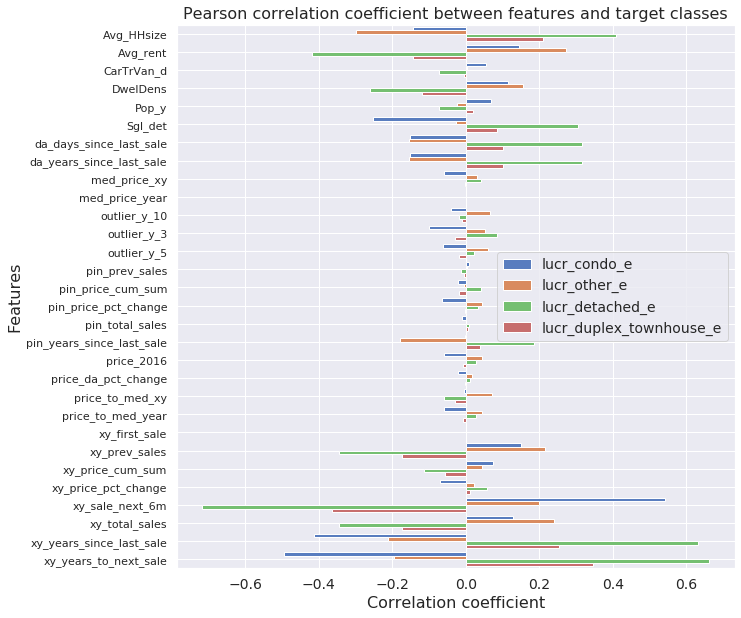

In [22]:
f, ax = plt.subplots(1, figsize=(10, 10))
sns.barplot(x="value", y="var", hue="variable", data=targets_corr_tidy,
            palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Correlation coefficient", fontsize=16)
ax.set_title("Pearson correlation coefficient between features and target classes", fontsize=16)
ax.grid(True)
ax.legend(loc='center right', fontsize=14)
plt.xticks(fontsize=14)
plt.savefig("../../results/plots/sbs30_features_lucr_corr.png", dpi=300, bbox_inches='tight')

## Prepare features

#### Select features and target

In [23]:
target_cols = 5
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'med_price_xy', 'med_price_year',
       'price_to_med_xy', 'price_to_med_year', 'outlier_y_3', 'outlier_y_5',
       'outlier_y_10', 'Avg_HHsize', 'Avg_rent', 'DwelDens', 'Sgl_det',
       'CarTrVan_d', 'Pop_y'],
      dtype='object')

In [24]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform train-test split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [45416 17484  5075 26758]
Labels counts in y_train: [31791 12239  3552 18731]
Labels counts in y_test: [13625  5245  1523  8027]
Labels counts in y_val1: [45961 19888  5889 24434]
Labels counts in y_val2: [41302 14895  4116 26329]


#### Standardize features

In [26]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [27]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


## Apply Sequential Backwards Selection (SBS) algorithm

In [28]:
X_train.shape

(66313, 30)

In [31]:
def fit_sbs(classifier, k_features, X, y, y_min=None, y_max=None, height=4, width=4,
            title="SBS", output='show', save_path='sbs.png', return_feats=True):
    t = time()

    sbs = SBS(classifier, k_features=k_features)

    sbs.fit(X, y)

    elapsed = time() - t
    print("Sequential Backwards Selection algorithm was applied. Took {0:,.2f} seconds, ({1:,.2f} minutes)."
          .format(elapsed, elapsed / 60))

    k_feat = [len(k) for k in sbs.subsets_]

    f, ax = plt.subplots(1, figsize=(width, height))
    plt.plot(k_feat, sbs.scores_, marker='o')
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    plt.grid()
    if output == 'show':
        plt.show()
    elif output == 'save':
        f.savefig(save_path, dpi=300, bbox_inches='tight')
    if return_feats:
        return sbs.subsets_

Sequential Backwards Selection algorithm was applied. Took 94.37 seconds, (1.57 minutes).


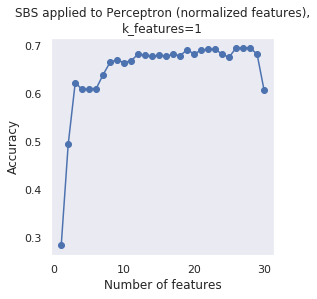

In [35]:
ppn = Perceptron(max_iter=100, eta0=0.01, random_state=1)
k_features = 1
model_name = "Perceptron (normalized features)"
save_name = 'ppn'
ppn_feats = fit_sbs(ppn, k_features, X_train_norm, y_train, output='save', 
            save_path='../../results/plots/sbs_sbs_{0}_kfeats_{1}.png'.format(save_name, k_features),
            title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

Sequential Backwards Selection algorithm was applied. Took 193.92 seconds, (3.23 minutes).


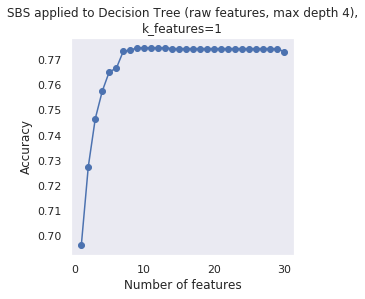

In [39]:
max_depth = 4
k_features = 1
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
model_name = 'Decision Tree (raw features, max depth {0})'.format(max_depth)
save_name = 'tree{0}'.format(max_depth)
tree_feats = fit_sbs(tree, k_features, X_train, y_train, output='save', 
                     save_path='../../results/plots/sbs_sbs_{0}_kfeats_{1}.png'.format(save_name, k_features),
                     title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

Sequential Backwards Selection algorithm was applied. Took 430.17 seconds, (7.17 minutes).


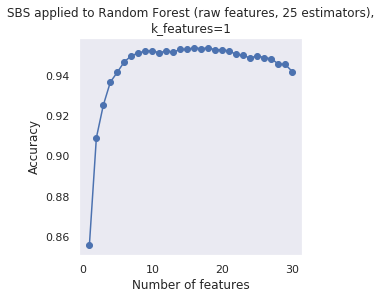

In [40]:
n_estimators = 25
k_features = 1
forest = RandomForestClassifier(criterion='gini', n_estimators=n_estimators, random_state=1, n_jobs=8)
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_estimators)
save_name = 'forest{0}'.format(n_estimators)
forest_feats = fit_sbs(forest, k_features, X_train, y_train, output='save', 
                       save_path='../../results/plots/sbs_sbs_{0}_kfeats_{1}.png'.format(save_name, k_features),
                       title="SBS applied to {0},\nk_features={1}".format(model_name, k_features))

### Try the model with a reduced feature selection

In [52]:
reduced_feats = feat_cols[list(tree_feats[-2])]
reduced_feats

Index(['xy_total_sales', 'Avg_HHsize'], dtype='object')

In [46]:
reduced_feats = feat_cols[list(tree_feats[-9])]
reduced_feats

Index(['xy_total_sales', 'pin_prev_sales', 'pin_years_since_last_sale',
       'med_price_xy', 'Avg_HHsize', 'DwelDens', 'Sgl_det', 'CarTrVan_d',
       'Pop_y'],
      dtype='object')

In [47]:
sbs9_cols = ['xy_total_sales', 'pin_prev_sales', 'pin_years_since_last_sale',
             'med_price_xy', 'Avg_HHsize', 'DwelDens', 'Sgl_det', 'CarTrVan_d', 'Pop_y']

In [48]:
X_rf = s[reduced_feats].values
X_rf_val1 = s_val1[reduced_feats].values
X_rf_val2 = s_val2[reduced_feats].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


In [49]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y, test_size=0.3, random_state=1, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [45416 17484  5075 26758]
Labels counts in y_train: [31791 12239  3552 18731]
Labels counts in y_test: [13625  5245  1523  8027]
Labels counts in y_val1: [45961 19888  5889 24434]
Labels counts in y_val2: [41302 14895  4116 26329]


In [50]:
max_depth = 4
model_name = 'Decision Tree (reduced feature selection, max_depth={0})'.format(max_depth)
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
fit_model(tree, model_name, X_rf_train, y_train, X_rf_test, y_test, X_rf_val1, y_val1, X_rf_val2, y_val2)


Decision Tree (reduced feature selection, max_depth=4) fit, took 0.34 seconds (0.01 minutes)
accuracy: train=0.77, test=0.77, validation #1=0.76, validation #2=0.75


In [51]:
max_depth = 20
model_name = 'Decision Tree (reduced feature selection, max_depth={0})'.format(max_depth)
tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
fit_model(tree, model_name, X_rf_train, y_train, X_rf_test, y_test, X_rf_val1, y_val1, X_rf_val2, y_val2)


Decision Tree (reduced feature selection, max_depth=20) fit, took 0.77 seconds (0.01 minutes)
accuracy: train=0.99, test=0.93, validation #1=0.91, validation #2=0.91


In [69]:
n_estimators = 25
model_name = 'Random Forest (raw features, {0} estimators)'.format(n_estimators)
forest = RandomForestClassifier(criterion='gini', n_estimators=n_estimators, random_state=1, n_jobs=8)
fit_model(forest, model_name, X_rf_train, y_train, X_rf_test, y_test, X_rf_val1, y_val1, X_rf_val2, y_val2)


Random Forest (raw features, 25 estimators) fit, took 2.80 seconds (0.05 minutes)
accuracy: train=1.00, test=0.95, validation #1=0.93, validation #2=0.92
